In [2]:
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.applications import ResNet50

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

import numpy as np
import pandas as pd
import tensorflow as tf
import random as rnd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from numpy import expand_dims

import os
import requests
import zipfile
import glob


from os import listdir
from os.path import isdir, isfile, join

In [3]:
def plot_augimages(paths, datagen):
### visualize augmented images generated using a Keras ImageDataGenerator ###
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Images')

    midx = 0 # matplotlib index
    for path in paths:
        data = Image.open(path)
        data = data.resize((224,224))
        ''' add an extra dimension to the data array.
        This step is often required to make the image compatible with the batch processing
        expected by many deep learning models. The expand_dims function adds an additional
        dimension at the beginning, effectively creating a batch of size 1 containing
        the resized image.'''
        samples = expand_dims(data, 0)
        '''This line sets up an iterator (it) using a Keras ImageDataGenerator (datagen).
        The iterator is configured to generate batches of data from the samples array,
        with each batch containing one image (batch_size=1).
        This iterator can be used to generate augmented versions of the image during training.'''
        it = datagen.flow(samples, batch_size=1)

        # Show Original Image
        plt.subplot(10,5, midx+1)
        plt.imshow(data)
        plt.axis('off')

        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10,5, midx+1)

            batch = it.next()
            image = batch[0].astype('uint8') # extracts the image data from the batch
            plt.imshow(image)
            plt.axis('off')
        midx += 1

    plt.tight_layout()
    plt.show()

In [4]:
def test_classifier(
    generator,
    y_test,
    classifier,
    scoring: str = 'f1-score'
    ): # -> dict[str, Union[ClassifierMixin, float]]:

    y_pred = classifier.predict(generator)

    #  cross_val_accuracy = cross_val_score(classifier, x_train, y_train, cv=5, scoring='accuracy')
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(
        f'Model: {classifier}\n\n'
        f'Accuracy: {accuracy} \n\n',
    #   f'Cross_val_accuracy: {cross_val_accuracy} \n\n',
        f'Recall: {recall} \n\n',
        f'Precision: {precision} \n\n',
        f'f1 score: {f1}'
        )

In [5]:
def plot_history(history):
    #Plot the Loss Curves
    plt.figure(figsize=[8,6])

    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)

    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.show()

    #Plot the Accuracy Curves
    plt.figure(figsize=[8,6])

    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    plt.show()

# Import data

In [6]:
target_directory = 'data/'

zip_url = 'https://www.muratkoklu.com/datasets/vtdhnd10.php'

os.makedirs(target_directory, exist_ok=True)
response = requests.get(zip_url)
zip_path = os.path.join(target_directory, 'data.zip')

with open(zip_path, 'wb') as zip_file:
    zip_file.write(response.content)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)

In [7]:
data_dir = os.path.join(target_directory, 'Grapevine_Leaves_Image_Dataset/*')

data = []
labels = []


for class_folder in glob.glob(data_dir):
    label = os.path.basename(class_folder)

    for image_path in glob.glob(os.path.join(class_folder, '*.png')):
        labels.append(label)
        data.append(image_path)

In [8]:
print(len(data))

500


# Split the data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Generators

In [10]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        pd.DataFrame({'path': X_train, 'class': y_train}),
        x_col='path',
        y_col='class',
        target_size=(227, 227),
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        pd.DataFrame({'path': X_val, 'class': y_val}),
        x_col='path',
        y_col='class',
        target_size=(227, 227),
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
test_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        pd.DataFrame({'path': X_test, 'class': y_test}),
        x_col='path',
        y_col='class',
        target_size=(227, 227),
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


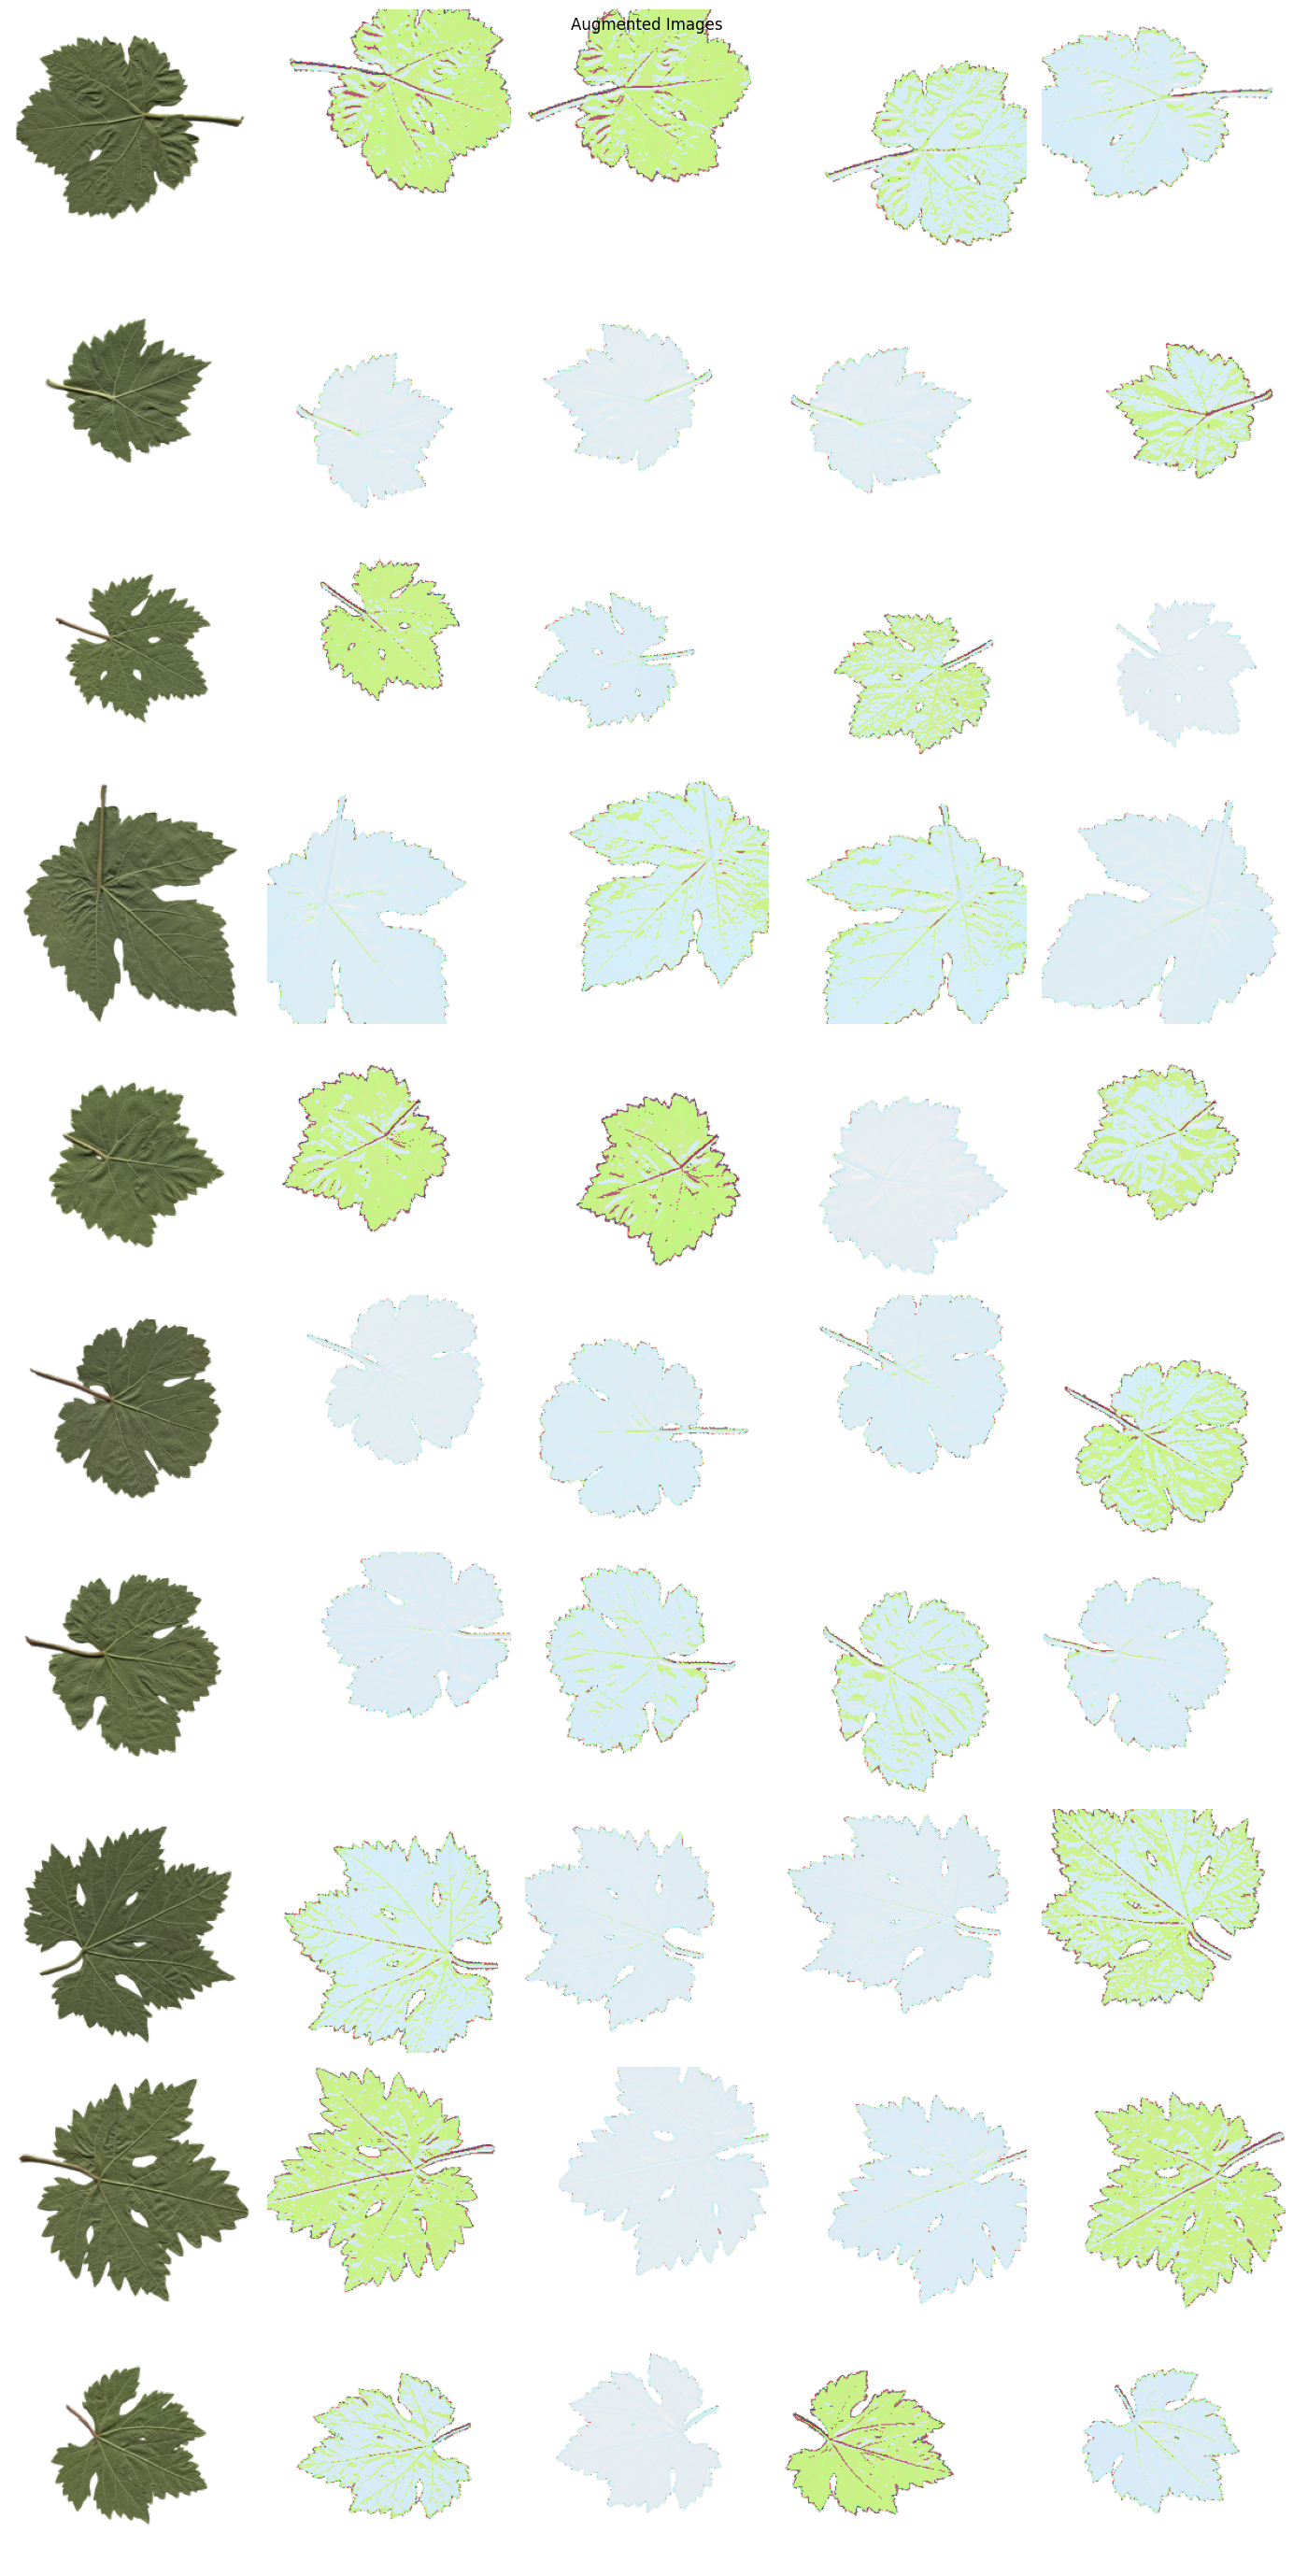

In [11]:
plot_augimages(np.random.choice(X_train, 10), resnet50_datagen)

In [21]:
# exclude the top (output) layer of the model
# initialize the model's weights with pre-trained weights from the ImageNet dataset
resnet50 = ResNet50(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false because we'd like to use pretrained layers
for layer in resnet50.layers:
    layer.trainable = False

# the last layer of the model is removed by taking the output from the last layer
x = resnet50.layers[-1].output


x = GlobalAveragePooling2D()(x)
predictions = Dense(5, activation='softmax')(x)

# the output tensor of the pre-trained ResNet-50 model
model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)

## Model compilation

In [22]:
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

## Model training

In [24]:
history_resnet50 = model_resnet50.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=50,
      callbacks=callback,
      verbose=2, #verbose=2 means that training progress will be displayed for each epoch, including metrics like loss and accuracy.
      )

Epoch 1/50
10/10 - 16s - loss: 1.8469 - accuracy: 0.2406 - val_loss: 1.5669 - val_accuracy: 0.3000 - 16s/epoch - 2s/step
Epoch 2/50
10/10 - 8s - loss: 1.5402 - accuracy: 0.3187 - val_loss: 1.4346 - val_accuracy: 0.4500 - 8s/epoch - 797ms/step
Epoch 3/50
10/10 - 9s - loss: 1.3604 - accuracy: 0.4531 - val_loss: 1.3344 - val_accuracy: 0.5250 - 9s/epoch - 904ms/step
Epoch 4/50
10/10 - 9s - loss: 1.2725 - accuracy: 0.4781 - val_loss: 1.2450 - val_accuracy: 0.5625 - 9s/epoch - 911ms/step
Epoch 5/50
10/10 - 9s - loss: 1.1188 - accuracy: 0.5938 - val_loss: 1.1705 - val_accuracy: 0.5875 - 9s/epoch - 896ms/step
Epoch 6/50
10/10 - 8s - loss: 1.0287 - accuracy: 0.6406 - val_loss: 1.0936 - val_accuracy: 0.6125 - 8s/epoch - 794ms/step
Epoch 7/50
10/10 - 9s - loss: 1.0341 - accuracy: 0.6219 - val_loss: 1.2024 - val_accuracy: 0.6000 - 9s/epoch - 920ms/step
Epoch 8/50
10/10 - 10s - loss: 0.9642 - accuracy: 0.6625 - val_loss: 0.9830 - val_accuracy: 0.6875 - 10s/epoch - 973ms/step
Epoch 9/50
10/10 - 12s 

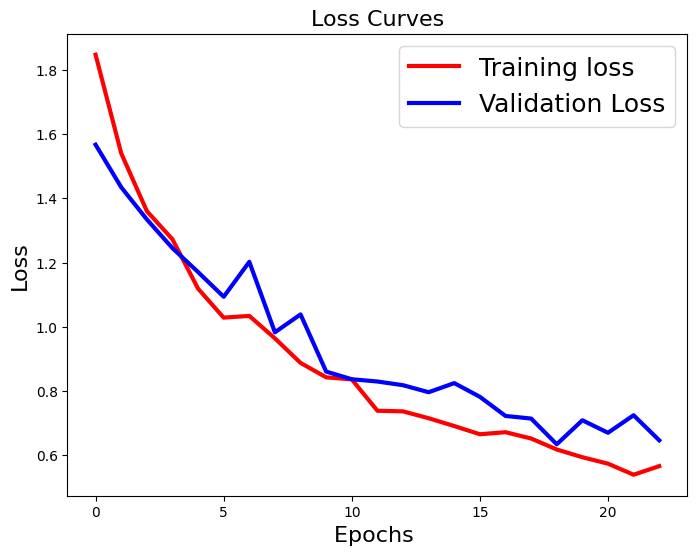

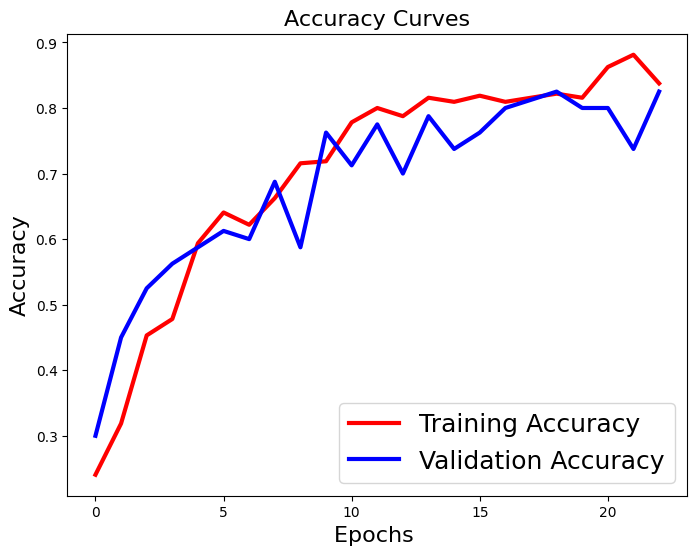

In [25]:
plot_history(history_resnet50)

In [ ]:
predictions = model_resnet50.predict(test_generator_resnet50)

4/4 [==============================] - 4s 526ms/step


In [ ]:
predictions = model_resnet50.predict(test_generator_resnet50)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator_resnet50.labels
print(classification_report(true_labels, predicted_labels))


4/4 [==============================] - 2s 436ms/step
              precision    recall  f1-score   support

           0       0.29      0.36      0.32        25
           1       0.06      0.05      0.05        21
           2       0.22      0.24      0.23        21
           3       0.08      0.07      0.07        15
           4       0.12      0.11      0.11        18

    accuracy                           0.18       100
   macro avg       0.15      0.16      0.16       100
weighted avg       0.16      0.18      0.17       100



# Previous approach

In [ ]:
img_width = 227
img_height = 227

EPOCHS = 20
BATCH_SIZE = 32

IMAGE_SHAPE = (img_width, img_height)

In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.1
)

In [ ]:
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_train, 'label': y_train}),
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    subset=None,
    class_mode='categorical',
    shuffle=True
)

validation_gen = datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_val, 'label': y_val}),
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset=None,
    shuffle=True
)


test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_test, 'label': y_test}),
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames.


In [ ]:
CLASSES = set(y_train)

## Inception model

In [ ]:
inception_v3 = InceptionV3(include_top= False , weights= None , input_shape = (img_width , img_height , 3))

In [ ]:
url = 'https://github.com/kohpangwei/influence-release/raw/master/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

weights_path = 'inception_v3_weights.h5'

response = requests.get(url)

if response.status_code == 200:
    with open(weights_path, 'wb') as f:
        f.write(response.content)
else:
    print("Nie udało się pobrać pliku.")

inception_v3.load_weights(weights_path)

In [ ]:
#freezing the layers so that they are not affected by the training on the new dataset
for layer in inception_v3.layers:
    layer.trainable = False

In [ ]:
last_layer = inception_v3.get_layer('mixed7') #I will put my output nodes on this layer
last_output = last_layer.output

In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(100 , activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(5 , activation = 'softmax')(x)
pre_trained_model = tf.keras.models.Model(inputs = inception_v3.input , outputs = x)

In [ ]:
pre_trained_model.compile(loss = tf.keras.losses.categorical_crossentropy , optimizer = tf.keras.optimizers.Adam() , metrics = ['accuracy'])

In [ ]:
history_pre_trained = pre_trained_model.fit(train_gen , epochs = EPOCHS , validation_data= validation_gen)

Epoch 1/20
10/10 [==============================] - 9s 593ms/step - loss: 7.9252 - accuracy: 0.2188 - val_loss: 2.0549 - val_accuracy: 0.2250
Epoch 2/20
10/10 [==============================] - 3s 261ms/step - loss: 1.6415 - accuracy: 0.3812 - val_loss: 1.3780 - val_accuracy: 0.3500
Epoch 3/20
10/10 [==============================] - 3s 259ms/step - loss: 1.2426 - accuracy: 0.4500 - val_loss: 1.4061 - val_accuracy: 0.4000
Epoch 4/20
10/10 [==============================] - 3s 342ms/step - loss: 1.0380 - accuracy: 0.5969 - val_loss: 1.2113 - val_accuracy: 0.5125
Epoch 5/20
10/10 [==============================] - 3s 325ms/step - loss: 0.8199 - accuracy: 0.7031 - val_loss: 1.0734 - val_accuracy: 0.5625
Epoch 6/20
10/10 [==============================] - 3s 261ms/step - loss: 0.6401 - accuracy: 0.7688 - val_loss: 0.9031 - val_accuracy: 0.6750
Epoch 7/20
10/10 [==============================] - 3s 258ms/step - loss: 0.5844 - accuracy: 0.7969 - val_loss: 0.7908 - val_accuracy: 0.7750
Epoch 

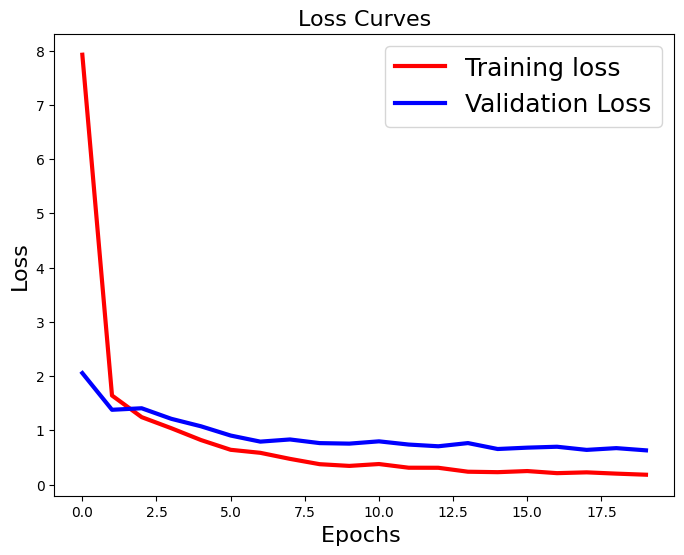

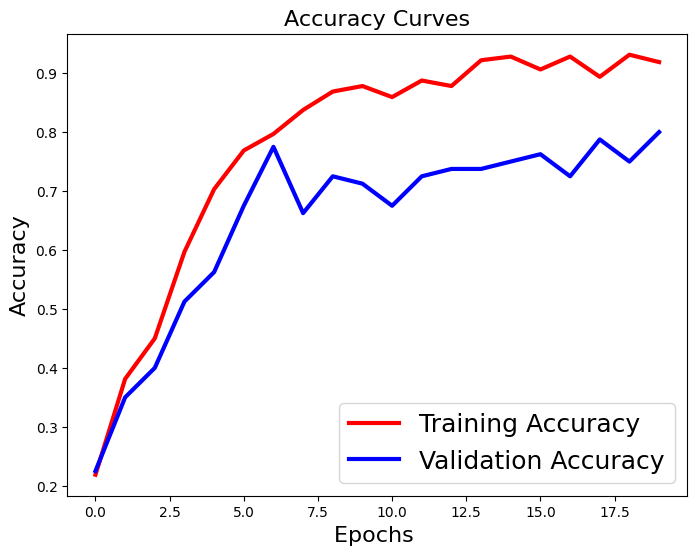

In [ ]:
plot_history(history_pre_trained)

## BASIC SEQUENTIAL MODEL

In [ ]:
model = Sequential()

# Add a 2D convolutional layer with 32 filters of size 3x3 and ReLU activation function
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))

# Add a MaxPooling layer to reduce the data size
model.add(MaxPooling2D((2, 2)))

# Add another 2D convolutional layer with 64 filters of size 3x3 and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))

# Add a 2D convolutional layer with 128 filters of size 3x3 and ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten the data into a one-dimensional array
model.add(Flatten())

# Add a dense layer with 512 units and ReLU activation
model.add(Dense(512, activation='relu'))

# Add an output layer with one neuron and a sigmoid activation function (binary classification)
model.add(Dense(len(CLASSES), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    validation_data=validation_gen,
    validation_steps=len(validation_gen)
)

Epoch 1/20
10/10 [==============================] - 4s 269ms/step - loss: 1.7678 - accuracy: 0.2344 - val_loss: 1.5784 - val_accuracy: 0.2250
Epoch 2/20
10/10 [==============================] - 2s 247ms/step - loss: 1.6121 - accuracy: 0.2125 - val_loss: 1.6017 - val_accuracy: 0.2625
Epoch 3/20
10/10 [==============================] - 4s 395ms/step - loss: 1.5428 - accuracy: 0.3094 - val_loss: 1.5678 - val_accuracy: 0.2750
Epoch 4/20
10/10 [==============================] - 3s 251ms/step - loss: 1.4728 - accuracy: 0.3812 - val_loss: 1.5386 - val_accuracy: 0.3375
Epoch 5/20
10/10 [==============================] - 3s 258ms/step - loss: 1.3945 - accuracy: 0.5219 - val_loss: 1.5444 - val_accuracy: 0.3625
Epoch 6/20
10/10 [==============================] - 3s 265ms/step - loss: 1.3102 - accuracy: 0.5406 - val_loss: 1.5097 - val_accuracy: 0.3500
Epoch 7/20
10/10 [==============================] - 3s 355ms/step - loss: 1.2323 - accuracy: 0.6125 - val_loss: 1.4912 - val_accuracy: 0.3125
Epoch 

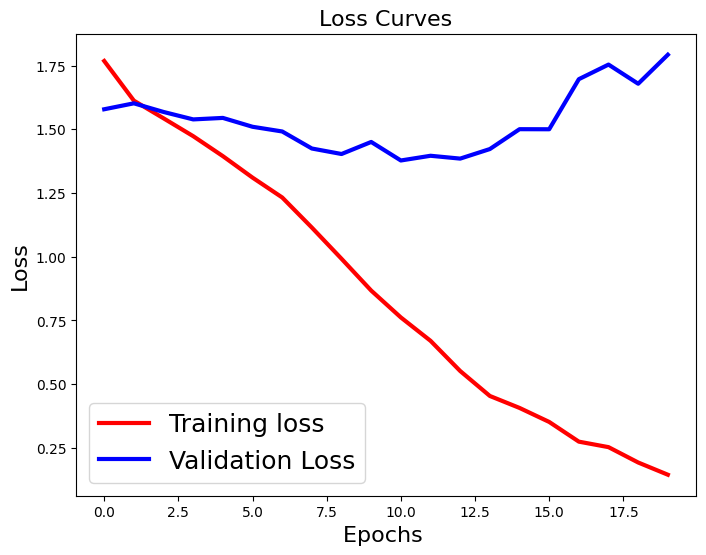

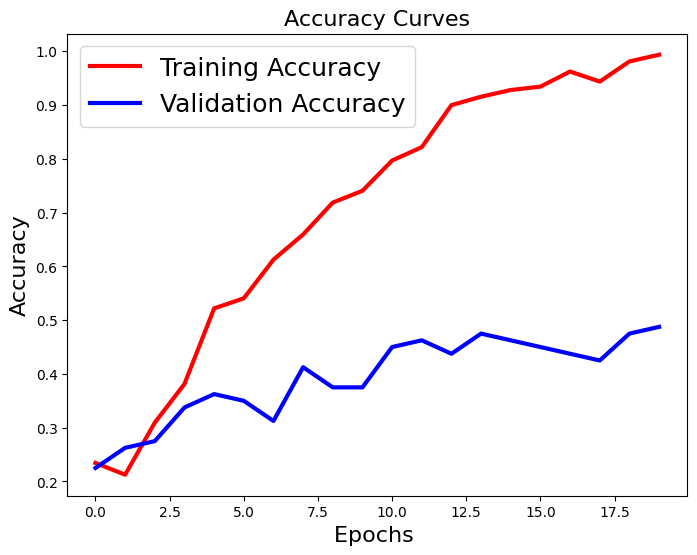

In [ ]:
plot_history(history)

In [ ]:
model.save('basic_model.keras')

# Model 1

### WITH DROPOUTS, BATCH_NORM AND EARLY STOPPING

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(CLASSES), activation='softmax'))

In [ ]:
# Compile the model
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=validation_gen.n//validation_gen.batch_size

history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    callbacks=[callback],
                    verbose=1
)

<ipython-input-148-08df381d4fb6>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen,


Epoch 1/20
10/10 [==============================] - 5s 343ms/step - loss: 2.2786 - accuracy: 0.3250 - val_loss: 6.9094 - val_accuracy: 0.2500
Epoch 2/20
10/10 [==============================] - 3s 288ms/step - loss: 1.0612 - accuracy: 0.6187 - val_loss: 37.6277 - val_accuracy: 0.1406
Epoch 3/20
10/10 [==============================] - 3s 261ms/step - loss: 0.7642 - accuracy: 0.7125 - val_loss: 46.2370 - val_accuracy: 0.0938
Epoch 4/20
10/10 [==============================] - 3s 265ms/step - loss: 0.5264 - accuracy: 0.8062 - val_loss: 23.8890 - val_accuracy: 0.2812
Epoch 5/20
10/10 [==============================] - 3s 288ms/step - loss: 0.3360 - accuracy: 0.8875 - val_loss: 18.6172 - val_accuracy: 0.2500
Epoch 6/20
10/10 [==============================] - 3s 302ms/step - loss: 0.2944 - accuracy: 0.9000 - val_loss: 11.2034 - val_accuracy: 0.2656
Epoch 7/20
10/10 [==============================] - 3s 267ms/step - loss: 0.1480 - accuracy: 0.9594 - val_loss: 9.9959 - val_accuracy: 0.3125
E

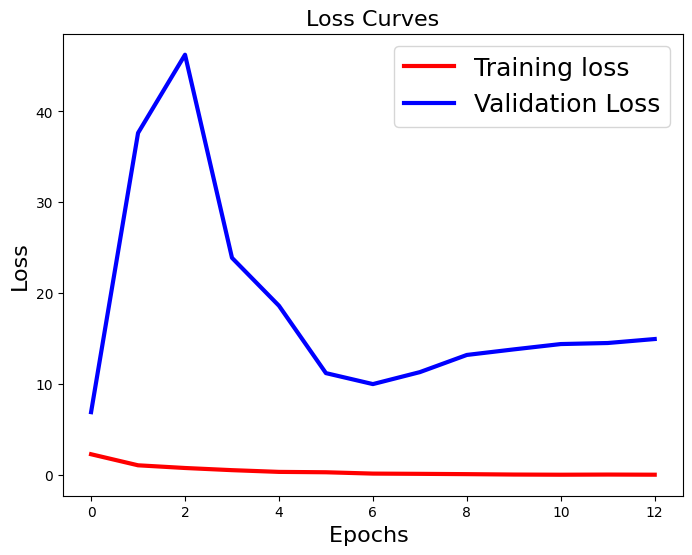

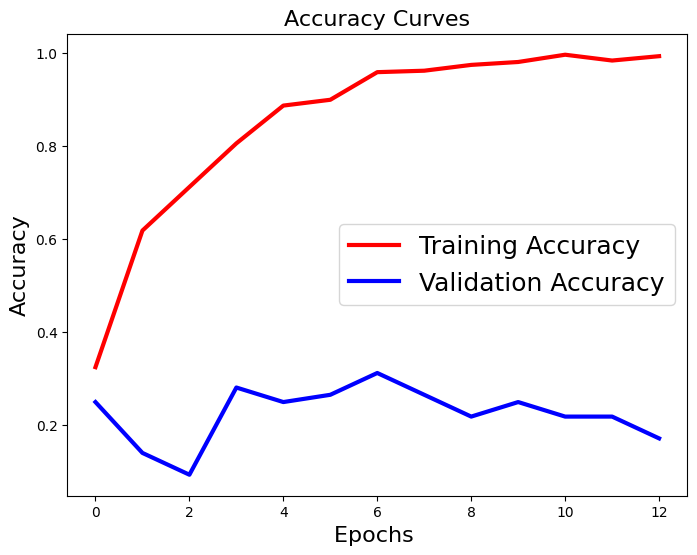

In [ ]:
plot_history(history)

In [ ]:
model.save('model1.keras')

In [ ]:


model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(CLASSES), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Model 2

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    validation_data=validation_gen,
    validation_steps=len(validation_gen),
    callbacks=callback
)

Epoch 1/20
10/10 [==============================] - 7s 292ms/step - loss: 2.3746 - accuracy: 0.3156 - val_loss: 1.7287 - val_accuracy: 0.2250
Epoch 2/20
10/10 [==============================] - 3s 274ms/step - loss: 0.5501 - accuracy: 0.8188 - val_loss: 1.7341 - val_accuracy: 0.2625
Epoch 3/20
10/10 [==============================] - 3s 273ms/step - loss: 0.2529 - accuracy: 0.9500 - val_loss: 2.2528 - val_accuracy: 0.2750
Epoch 4/20
10/10 [==============================] - 3s 332ms/step - loss: 0.1300 - accuracy: 0.9906 - val_loss: 2.8554 - val_accuracy: 0.2125
Epoch 5/20
10/10 [==============================] - 3s 285ms/step - loss: 0.0899 - accuracy: 0.9875 - val_loss: 3.2910 - val_accuracy: 0.2125
Epoch 6/20
10/10 [==============================] - 3s 264ms/step - loss: 0.0446 - accuracy: 0.9969 - val_loss: 3.5557 - val_accuracy: 0.2125
Epoch 7/20
10/10 [==============================] - 3s 264ms/step - loss: 0.0301 - accuracy: 1.0000 - val_loss: 3.6060 - val_accuracy: 0.2250
Epoch 

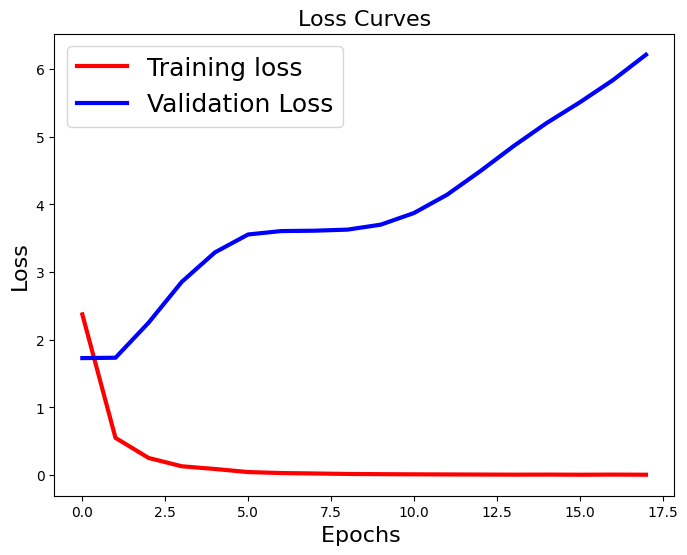

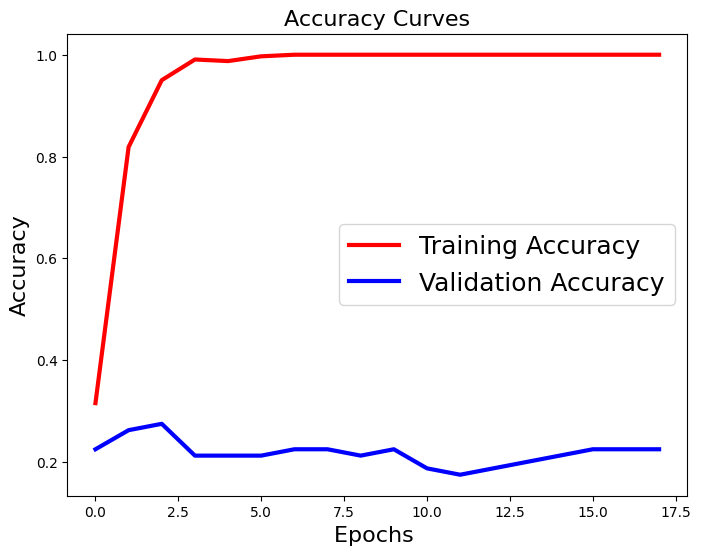

In [ ]:
plot_history(history)